In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.patches import Patch
import seaborn as sns

# To import scripts from different directory
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, "/".join([parent_dir, "src"])) 

from utils import *
from BayesNN import BNN
from rate_bnn import *

/home/jonathan/miniconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:22: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .linbin import fast_linbin
/home/jonathan/miniconda2/lib/python2.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:11: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._smoothers_lowess import lowess as _lowess


# Build and train network, compute RATE

Do this once each for binary tasks distringuising MNIST 0 from 1 and 1 from 8.

In [2]:
tf.reset_default_graph()

# Settings
class_set_list = [[0,1], [8,1]]

crop_size = 5

# Training settings
n_epochs = 10
batch_size = 256

# Test settings - the number of posterior samples
n_test_samples = 100

# Network architecture
def network_layers(p, C, image_size):
    layers = []
    layers.append(tf.keras.layers.Reshape([image_size, image_size, 1], input_shape=(p,)))
    layers.append(tf.keras.layers.Conv2D(32, (5, 5), activation='relu'))
    layers.append(tf.layers.Flatten())
    layers.append(tf.keras.layers.Dense(512, activation='relu'))
    layers.append(tfp.layers.DenseLocalReparameterization(C))
    return layers

rate_values, M_B_signs = [], []

for classes in class_set_list:
    x_train, y_train, x_test, y_test = load_mnist(False, True, crop_size, classes) # Load data
    
    p = x_train.shape[1]
    C = y_train.shape[1]
    image_size = int(p**0.5)
    
    bnn = BNN(network_layers(p, C, image_size), p, C, False) # Create and train network
    losses = bnn.train(x_train, y_train, n_epochs, batch_size)
    
    test_logits = bnn.sample_logits(x_test, n_test_samples) # Sample logits
    test_acc = sampled_accuracies(test_logits, y_test)
    print "Test accuracy = {} \pm {}".format(test_acc.mean(), test_acc.std())
    
    # Compute RATE
    M_W, V_W, b = bnn.var_params() # Means and covariances of the variational parameters (final layer weight matrix elements)
    X = x_test
    H = bnn.compute_H(X) # (Deterministic) activations of penultimate network layer
    M_B, V_B = compute_B(X, H, M_W, V_W, b, C, effect_size_analogue="covariance") # Means and covariances of the effect size analogues
    rate_values.append(RATE(mu_c=M_B[0,:], Lambda_c=V_B[0,:,:]))
    
    M_B_signs.append(np.sign(M_B[0,:]))


x_train has shape (12665, 324)
y_train has shape (12665, 1)
x_test has shape (2115, 324)
y_test has shape (2115, 1)
Test accuracy = 0.999418439716 \pm 0.000209909909035
0 100 200 300 x_train has shape (12593, 324)
y_train has shape (12593, 1)
x_test has shape (2109, 324)
y_test has shape (2109, 1)
Test accuracy = 0.999473684211 \pm 0.000275624307811
0 100 200 300


# Plot RATE

In [15]:
RATE_BNN(x_test, H, M_W, V_W, b, C, effect_size_analogue="covariance")

AttributeError: 'int' object has no attribute 'shape'

In [14]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

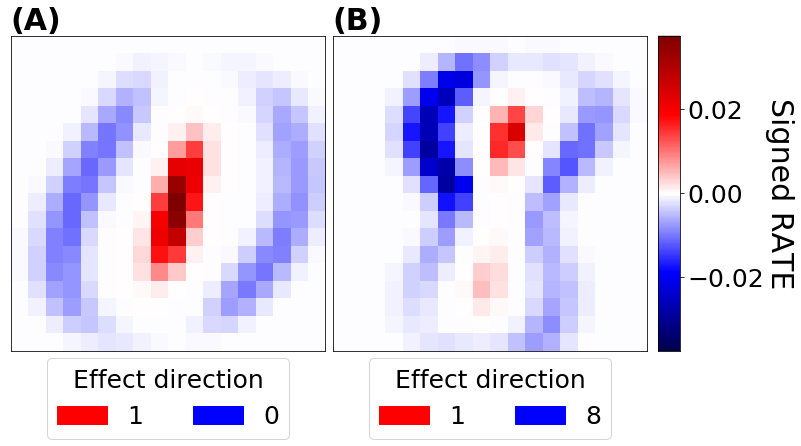

In [104]:
#
# Plot RATE values for each binary task
#

rate_values_signed = [np.sign(M_B_signs[i]) * rate_values[i] for i in range(2)]

# Plot aesthetics
plotsize = 6
tickfontsize = 25
plottitlesize = 40
axislabelfontsize = 30
markersize = 100
legendfontsize = 20

titles = ["(A)", "(B)"]

# Standardise scales across plots
vmax, vmin = np.amax(rate_values_signed), np.amin(rate_values_signed)
abs_limit = np.amax([vmax, np.abs(vmin)])

# Set up figure and image grid
fig = plt.figure(figsize=(2*plotsize, plotsize))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,2),
                 axes_pad=0.1,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15)

# Add data to image grid
for i, ax in enumerate(grid):
    im = ax.imshow(rate_values_signed[i].reshape(image_size, image_size),
                   cmap="seismic", vmin=-abs_limit, vmax=abs_limit)
    
    ax.set_xticks([])
    ax.get_yaxis().set_visible(False)
#     ax.set_xlabel("Distinguishing\n{} and {}".format(class_set_list[i][0], class_set_list[i][1]),
#                   fontsize=axislabelfontsize)
    ax.set_title(titles[i], loc="left", weight="bold", fontsize=axislabelfontsize)
    
    legend_elements = [Patch(facecolor=c, edgecolor=c, label=l, alpha=1.0) for (c,l) in 
                   zip(["red", "blue"], ["{}".format(class_set_list[i][1]),
                                         "{}".format(class_set_list[i][0])])]
    
    legend = ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.32),
               ncol=2, fancybox=True, title="Effect direction", 
                   fontsize=tickfontsize)
    legend.get_title().set_fontsize(tickfontsize)
    


# Colorbar
cb = ax.cax.colorbar(im)

ax.cax.set_ylabel("Signed RATE", rotation=270, fontsize=axislabelfontsize, labelpad=30)
ax.cax.yaxis.offsetText.set_fontsize(tickfontsize)
ax.cax.tick_params("both", labelsize=tickfontsize)

fig.savefig("MNIST_visualisation.pdf", bbox_inches="tight")